# "Seq2Seq 기계 번역"
> "Dive into deep learning의 Seq2Seq 학습 내용을 재구현해 보았다."

- toc: true
- badges: true
- author: 단호진
- categories: [nlp]

이 포스트에는 [Dive into Deep Learning 9장의 Seq2Seq](https://d2l.ai/chapter_recurrent-modern/seq2seq.html) 코드를 재구현하였다. Seq2Seq 학습의 배경이나 자세한 내용은 d2l 누리집에 들어있으나, 직접 작성해보고 나서야 코드의 자세한 부분을 이해할 수 있었다.

Seq2Seq 학습을 통하여 해결하고자 하는 문제는 Fig. 9.7.1에 나타나 있다. 영어 문장에서 출발하여 불어로 도착하는 번역을 하고자 한다. 이 문제를 풀기 위하여 생성 모델이 가능한 오토인코더 구조로 Seq2Seq 모델을 개발하였다. 도착어 입장에서 입력과 출력은 같으며 bos(begin of sentence), eos(end of sentence) 토큰 차이만 있다.

![Fig. 9.7.1 Sequence to sequence learning with an RNN encoder and an RNN decoder.](https://d2l.ai/_images/seq2seq.svg)
**Fig. 9.7.1 Sequence to sequence learning with an RNN encoder and an RNN decoder.**

In [1]:
from d2l import torch as d2l
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

## Data

출발과 도착어의 문장은 184, 201개의 어휘로 구성되는 작은 데이터셋이다. 문장 시작 bos, 문장 끝 eos, 채움 pad, 모름 unk 등의 특별한 의미를 갖는 단어/토큰도 이용한다. 출발·도착 문장은 뜻은 대응되나 길이가 다를 수 있고, eos 이후 seq_len를 보장하기 위하여 pad가 삽입되어 있다. valid_len에 유효 토큰의 수가 들어있다.

In [2]:
batch_size, seq_len = 64, 10

train_iter, src_vocab, dst_vocab = d2l.load_data_nmt(batch_size, seq_len)

len(src_vocab), len(dst_vocab)

(184, 201)

In [3]:
'|'.join([src_vocab.idx_to_token[k] for k in range(10)])

"<unk>|<pad>|<bos>|<eos>|.|!|i|i'm|it|go"

In [4]:
for batch in train_iter:
    x, x_valid_len, y, y_valid_len = batch
    break
    
x.shape, x_valid_len.shape, y.shape, y_valid_len.shape

(torch.Size([64, 10]),
 torch.Size([64]),
 torch.Size([64, 10]),
 torch.Size([64]))

In [5]:
print(f'number of valid tokens: {x_valid_len[0]}')
' '.join([src_vocab.idx_to_token[i] for i in x[0]])

number of valid tokens: 4


"i'm hit ! <eos> <pad> <pad> <pad> <pad> <pad> <pad>"

In [6]:
print(f'number of valid tokens: {x_valid_len[0]}')
' '.join([dst_vocab.idx_to_token[i] for i in y[0]])

number of valid tokens: 4


'je suis <unk> ! <eos> <pad> <pad> <pad> <pad> <pad>'

## Seq2Seq model

모델의 구조 특징은 다음과 같다.

* 오토인코더를 생성 모델로 사용하기 위하여 부호기 Encoder와 복호기 Decoder의 RNN 은닉 스테이트를 공유
* 은닉 스테이트의 마지막 층은 context로 칭하여 입력에 주입

In [7]:
class Seq2SeqEnc(nn.Module):
    def __init__(self, src_vocab_size, embed_dim, hidden_size, num_layers, dropout=0.0):
        super().__init__()
        self.embedding = nn.Embedding(src_vocab_size, embed_dim)
        self.rnn = nn.GRU(embed_dim, hidden_size, num_layers, dropout=dropout)
        
    def forward(self, x):
        x = self.embedding(x).permute(1, 0, 2)
        out, state = self.rnn(x)
        return out, state
    
    
class Seq2SeqDec(nn.Module):
    def __init__(self, dst_vocab_size, embed_dim, hidden_size, num_layers, dropout=0.0):
        super().__init__()
        self.embedding = nn.Embedding(dst_vocab_size, embed_dim)
        self.rnn = nn.GRU(embed_dim + hidden_size, hidden_size, num_layers, dropout=dropout)
        self.linear = nn.Linear(hidden_size, dst_vocab_size)
        
    def forward(self, y, state):
        y = self.embedding(y).permute(1, 0, 2)
        context = state[-1].repeat(y.shape[0], 1, 1)  # batch x hidden -> seq x batch x hidden
        out, state = self.rnn(torch.cat([y, context], -1), state)
        out = self.linear(out).permute(1, 0, 2)
        # out.shape batch x seq x dst vocab
        # state.shape layers x batch x hidden
        return out, state
    

class Seq2SeqEncDec(nn.Module):
    def __init__(self, src_vocab_size, dst_vocab_size, embed_dim, hidden_size, num_layers, dropout=0.0):
        super().__init__()
        self.enc = Seq2SeqEnc(src_vocab_size, embed_dim, hidden_size, num_layers, dropout)
        self.dec = Seq2SeqDec(dst_vocab_size, embed_dim, hidden_size, num_layers, dropout)
        
    def forward(self, x, y):
        _, state = self.enc(x)
        out, state = self.dec(y, state)
        return out, state

## Loss function

* 도착어의 입력 문장 머리에 bos를 삽입
* 문장마다 의미 있는 토큰 수가 다르므로 마스크 트릭을 사용

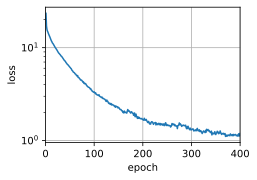

In [8]:
embed_dim, hidden_size, num_layers, dropout = 32, 32, 3, 0.1
batch_size, seq_len = 128, 10
lr, epochs, device = 0.01, 400, torch.device('cpu')  # d2l.try_gpu()

train_iter, src_vocab, dst_vocab = d2l.load_data_nmt(batch_size, seq_len)

mod_1 = Seq2SeqEncDec(len(src_vocab), len(dst_vocab), embed_dim, hidden_size, num_layers, dropout)
mod_1.to(device)
optimizer = torch.optim.Adam(mod_1.parameters(), lr=lr)
loss = nn.CrossEntropyLoss()

animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[0, epochs], yscale='log')

mod_1.train()
for epoch in range(1, epochs + 1):
    losses = 0
    for batch in train_iter:
        X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
        bos = torch.tensor([dst_vocab['<bos>']] * Y.shape[0], device=device).reshape((-1, 1))
        Y_in = torch.cat([bos, Y[:, :-1]], -1)
        Y_hat, _ = mod_1(X, Y_in)
        mask = torch.arange(seq_len).unsqueeze(0).to(device) < Y_valid_len.unsqueeze(-1)
        mask = mask.reshape(-1)
        Y_hat = Y_hat.reshape((-1, len(dst_vocab)))
        Y = Y.reshape(-1)
        l = loss(Y_hat[mask], Y[mask])
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        losses += l.item()
    animator.add(epoch, [losses])

## Prediction

출발어 영어 입력에서 도착어 불어 생성은 ᅟpredict 함수를 이용한다. 내부절차는 다음과 같다.

* 모델의 Encoder와 Decoder를 별개로 활용
* Decoder는 토큰별로 하나씩 처리하여 문장을 생성

In [9]:
def predict(model: Seq2SeqEncDec, src_sentence, src_vocab, dst_vocab, seq_len, device):
    model.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<eos>']]
    src_valid_len = torch.tensor([min(seq_len, len(src_tokens))], device=device)
    src_tokens = src_tokens[:seq_len]
    src_tokens = src_tokens + [src_vocab['<pad>']] * max(0, seq_len - len(src_tokens))
    src_tokens = torch.tensor(src_tokens, device=device).unsqueeze(0)  # add batch dim
    
    _, state = model.enc(src_tokens)
    y = torch.tensor([dst_vocab['<bos>']], dtype=torch.long, device=device).unsqueeze(0)
    out = []
    for _ in range(seq_len):
        y, state = model.dec(y, state)
        y = y.argmax(dim=-1)
        pred = y.squeeze(0).long().item()
        if pred == dst_vocab['<eos>']:
            break
        out.append(pred)
    
    return ' '.join(dst_vocab.to_tokens(out))

In [10]:
predict(mod_1, "i lost .", src_vocab, dst_vocab, 10, device)

"j'ai perdu ."

## Evaluation

d2l의 코드를 거의 그대로 사용하였다. 샘플 결과만 가지고도 성능이 좋지 않은 것을 알 수 있다. 훈련 데이터가 적기도 하지만 Seq2Seq 자체만으로는 한계가 있기 때문이다. Seq2Seq 성능 개선을 위하여 어텐션 등이 개발되었으며 이에 대한 얘기는 다음으로 미루겠다. 다만 Seq2Seq 차체만으로도 RNN 이해를 위한 연습문제로 손색이 없었다.

In [11]:
import collections

def bleu(pred_seq, label_seq, k):  #@save
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = np.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[''.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[''.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[''.join(pred_tokens[i: i + n])] -= 1
        score *= np.power(num_matches / (len_pred - n + 1), np.power(0.5, n))
    return score


engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation = predict(
        mod_1, eng, src_vocab, dst_vocab, seq_len, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => bonne chance ., bleu 0.000
i'm home . => je suis chez moi bon ., bleu 0.803
